# Carregamento de Dados

Objetivos dessa aula:
* Carregar um dataset customizado
* Implementar o fluxo de treinamento **e validação** completo de uma rede


## Hiperparâmetros

Vamos manter a organização do último script :)

* imports de pacotes
* configuração de hiperparâmetros
* definição do hardware padrão utilizado

E bora de GPU de novo! 


In [1]:
import torch
from torch import nn
from torch import optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import time
import copy


import matplotlib.pyplot as plt
%matplotlib inline

# Configurando hiperparâmetros.
args = {
    'epoch_num': 200,               # Número de épocas.
    # 'lr': 5e-5,                   # Taxa de aprendizado.
    'lr': 1e-3,                     # Taxa de aprendizado.
    # 'weight_decay': 5e-4,         # Penalidade L2 (Regularização).
    'weight_decay': 1e-5,           # Penalidade L2 (Regularização).
    'num_workers': 3,               # Número de threads do dataloader.
    'batch_size': 20,               # Tamanho do batch.
    'early_stopping_patience': 20,  # Épocas sem melhoria antes de interromper.
}

# if torch.cuda.is_available():
#     args['device'] = torch.device('cuda')
# else:
#     args['device'] = torch.device('cpu')

args['device'] = torch.device('cpu')

print(args['device'])

cpu


In [2]:
# Sementes para garantir reprodutibilidade de operações pseudoaleatórias.
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(42)


## Dataset 

Dataset de aplicativos para aluguel de bicicletas (*Bike Sharing Dataset*). <br>
* Dadas algumas informações como velocidade do vento, estação do ano, etc., quantas bicicletas serão alugadas na próxima hora?

Esse é um problema de **Regressão**, onde precisamos estimar uma variável dependente em um espaço contínuo (alugueis de bikes) a partir de um conjunto de variáveis independentes (as condições no momento).

### Baixando o dataset

Fonte: https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset



In [3]:
# ! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
# ! unzip Bike-Sharing-Dataset.zip  

### Visualizando os dados

In [4]:
df = pd.read_csv('hour.csv')
print(len(df))
df.head()

17379


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Tratamento de dados

**Variáveis Categóricas** <br>
Como descrito na página do dataset, apenas as variáveis numéricas estão normalizadas. No caso das categóricas (como dia da semana e estação do ano), cada elemento contém o índice da categoria.

Existem várias formas de lidar com variáveis categóricas em uma regressão, mas para não desviar o foco da nossa aula manteremos os valores originais das variáveis categóricas.

**Separação em treino e teste**<br>

Para treinar e validar o nosso modelo, precisamos de dois conjuntos de dados (treino e teste). Para isso, utilizaremos a função ```torch.randperm``` para amostrar aleatoriamente um percentual dos dados, separando-os para validação.

Documentação: https://pytorch.org/docs/stable/torch.html#torch.randperm

In [5]:
# Train/Test split
indices = torch.randperm(len(df)).tolist()

train_size = int(0.8*len(df))
df_train = df.iloc[indices[:train_size]]
df_test  = df.iloc[indices[train_size:]]

print(len(df_train), len(df_test))
display(df_test.head())

df_train.to_csv('bike_train.csv',index=False)
df_test.to_csv('bike_test.csv',index=False)
# !ls

13903 3476


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
12449,12450,2012-06-07,2,1,6,22,0,4,1,1,0.60,0.6212,0.46,0.1642,35,193,228
10100,10101,2012-03-01,1,1,3,22,0,4,1,1,0.38,0.3939,0.50,0.2537,3,123,126
1090,1091,2011-02-18,1,0,2,4,0,5,1,1,0.46,0.4545,0.67,0.2537,0,1,1
3321,3322,2011-05-23,2,0,5,7,0,1,1,2,0.56,0.5303,0.94,0.1045,13,223,236
15679,15680,2012-10-20,4,1,10,12,0,6,0,1,0.56,0.5303,0.46,0.1045,267,436,703


In [6]:
class Bicicletinha(Dataset):
  def __init__(self, csv_path, scaler_feat=None, scaler_label=None):
  
    self.dados = pd.read_csv(csv_path).to_numpy()
    self.scaler_feat = scaler_feat
    self.scaler_label = scaler_label
    
  def __getitem__(self, idx):
    
    sample = self.dados[idx][2:14].astype(np.float32)
    label  = self.dados[idx][-1:].astype(np.float32)
    
    if self.scaler_feat is not None:
      sample = self.scaler_feat.transform(sample.reshape(1, -1)).squeeze(0).astype(np.float32)
    if self.scaler_label is not None:
      label = self.scaler_label.transform(label.reshape(1, -1)).squeeze(0).astype(np.float32)
    
    # converte para tensor
    sample = torch.from_numpy(sample)
    label  = torch.from_numpy(label)
    
    return sample, label
    
  def __len__(self):
    return len(self.dados)


In [7]:
# Ajusta os scalers usando apenas o conjunto de treino para evitar vazamento de informação.
feature_scaler = StandardScaler()
feature_scaler.fit(df_train.iloc[:, 2:14].values.astype(np.float32))

# Mantemos o alvo (contagem de bikes) na escala original para facilitar a interpretação da loss.
label_scaler = None


In [8]:
dataset = Bicicletinha('bike_train.csv', scaler_feat=feature_scaler, scaler_label=label_scaler)
# dataset = Bicicletinha('bike_train.csv', scaler_feat=None, scaler_label=None)

dado, rotulo = dataset[0]
print(rotulo)
print(dado)


tensor([117.])
tensor([-0.4539, -1.0044, -0.7338,  1.5141, -0.1748, -0.0025,  0.6825, -0.6661,
         0.6382,  0.8470, -1.1226,  0.5201])


In [9]:
train_set = Bicicletinha('bike_train.csv', scaler_feat=feature_scaler, scaler_label=label_scaler)
test_set  = Bicicletinha('bike_test.csv', scaler_feat=feature_scaler, scaler_label=label_scaler)
# train_set = Bicicletinha('bike_train.csv', scaler_feat=None, scaler_label=None)
# test_set  = Bicicletinha('bike_test.csv', scaler_feat=None, scaler_label=None)


print('Tamanho do treino: ' + str(len(train_set)) + ' amostras')
print('Tamanho do teste: ' + str(len(test_set)) + ' amostras')


Tamanho do treino: 13903 amostras
Tamanho do teste: 3476 amostras


## Dataloader


In [10]:
# Criando dataloader
train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

O objeto retornado é um **iterador**, podendo ser utilizado para iterar em loops mas não suportando indexação.

In [11]:
for batch in test_loader:
  
  dado, rotulo = batch
  print('## Dimensionalidade do batch ##')
  print(dado.size(), rotulo.size())
  
  break

## Dimensionalidade do batch ##
torch.Size([20, 12]) torch.Size([20, 1])


## Implementando o MLP

Essa parte aqui você já tira de letra! Minha sugestão é construir um modelo com:

* **Duas camadas escondidas**. Lembre-se de alternar as camadas com ativações não-lineares. 
* Uma camada de saída (com qual ativação?)

In [12]:
class MLP(nn.Module):
  """Rede para regressão do conjunto Bike Sharing (saída contínua)."""
  def __init__(self, input_size, hidden_size, out_size):
    super(MLP, self).__init__()

    self.features = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, hidden_size),
          nn.ReLU(),
    )

    # Camada final retorna um valor contínuo; sem ativação para manter a escala do target.
    self.regressor = nn.Linear(hidden_size, out_size)

  def forward(self, X):

    hidden = self.features(X)
    output = self.regressor(hidden)

    return output

input_size  = train_set[0][0].size(0)
hidden_size = 128
out_size    = 1

net = MLP(input_size, hidden_size, out_size).to(args['device'])
print(net)


MLP(
  (features): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (regressor): Linear(in_features=128, out_features=1, bias=True)
)


## Definindo loss e otimizador

Se lembra quais as funções de perda adequadas para um problema de regressão?

In [13]:
criterion = nn.L1Loss().to(args['device'])

optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

# Fluxo de Treinamento & Validação

## Treinamento

Relembrando o passo a passo do fluxo de treinamento:
* Iterar nas épocas
* Iterar nos batches
* Cast dos dados no dispositivo de hardware
* Forward na rede e cálculo da loss
* Cálculo do gradiente e atualização dos pesos

Esse conjunto de passos é responsável pelo processo iterativo de otimização de uma rede. **A validação** por outro lado, é apenas a aplicação da rede em dados nunca antes visto para estimar a qualidade do modelo no mundo real.

## Validação

Para essa etapa, o PyTorch oferece dois artifícios:
* ```model.eval()```: Impacta no *forward* da rede, informando as camadas caso seu comportamento mude entre fluxos (ex: dropout).
* ```with torch.no_grad()```: Gerenciador de contexto que desabilita o cálculo e armazenamento de gradientes (economia de tempo e memória). Todo o código de validação deve ser executado dentro desse contexto.

Exemplo de código para validação

```python
net.eval()
with torch.no_grad():
  for batch in test_loader:
      # Código de validação
```

Existe o equivalente ao ```model.eval()``` para explicitar que a sua rede deve estar em modo de treino, é o ```model.train()```. Apesar de ser o padrão dos modelos, é boa prática definir também o modo de treinamento.

In [14]:
def train(train_loader, net, epoch):

  # Training mode
  net.train()

  start = time.time()

  epoch_loss = []
  for batch in train_loader:

    dado, rotulo = batch

    # Cast do dado na GPU
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    # Limpa gradientes acumulados antes da próxima atualização.
    optimizer.zero_grad()

    # Forward
    ypred = net(dado)
    loss = criterion(ypred, rotulo)
    epoch_loss.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

  epoch_loss = np.asarray(epoch_loss)

  end = time.time()
  print('#################### Train ####################')
  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))

  return epoch_loss.mean()



In [15]:
def validate(test_loader, net, epoch):

  # Evaluation mode
  net.eval()
  
  start = time.time()
  
  epoch_loss  = []
  
  with torch.no_grad(): 
    for batch in test_loader:

      dado, rotulo = batch

      # Cast do dado na GPU
      dado = dado.to(args['device'])
      rotulo = rotulo.to(args['device'])

      # Forward
      ypred = net(dado)
      loss = criterion(ypred, rotulo)
      epoch_loss.append(loss.item())

  epoch_loss = np.asarray(epoch_loss)
  
  end = time.time()
  print('********** Validate **********')
  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))
  
  return epoch_loss.mean()
    

In [16]:
train_losses, test_losses = [], []
best_val_loss = float('inf')
best_epoch = -1
best_state_dict = None
patience = args.get('early_stopping_patience')
patience_counter = 0

for epoch in range(args['epoch_num']):
  
  # Train
  train_losses.append(train(train_loader, net, epoch))
  
  # Validate
  current_val_loss = validate(test_loader, net, epoch)
  test_losses.append(current_val_loss)
  
  if current_val_loss < best_val_loss - 1e-6:
    best_val_loss = current_val_loss
    best_epoch = epoch
    patience_counter = 0
    best_state_dict = copy.deepcopy(net.state_dict())
  else:
    if patience is not None:
      patience_counter += 1
      if patience_counter >= patience:
        print(f'Early stopping triggered at epoch {epoch} (best epoch: {best_epoch} | val loss: {best_val_loss:.4f})')
        break

if best_state_dict is not None:
  net.load_state_dict(best_state_dict)
  print(f'Modelo restaurado para o estado da época {best_epoch} (val loss: {best_val_loss:.4f}).')


#################### Train ####################
Epoch 0, Loss: 111.1179 +/- 38.5980, Time: 4.56
********** Validate **********
Epoch 0, Loss: 98.9120 +/- 24.8763, Time: 1.00

#################### Train ####################
Epoch 1, Loss: 95.7882 +/- 24.6386, Time: 5.29
********** Validate **********
Epoch 1, Loss: 94.5523 +/- 24.9254, Time: 0.75

#################### Train ####################
Epoch 2, Loss: 91.6178 +/- 22.9401, Time: 4.11
********** Validate **********
Epoch 2, Loss: 89.2079 +/- 23.3240, Time: 0.82

#################### Train ####################
Epoch 3, Loss: 86.5720 +/- 23.3823, Time: 4.86
********** Validate **********
Epoch 3, Loss: 84.0557 +/- 22.5014, Time: 0.78

#################### Train ####################
Epoch 4, Loss: 81.5775 +/- 21.2729, Time: 4.14
********** Validate **********
Epoch 4, Loss: 79.0041 +/- 21.8050, Time: 0.82

#################### Train ####################
Epoch 5, Loss: 76.3225 +/- 21.5515, Time: 3.95
********** Validate **********
Epo

In [17]:
Xtest = torch.stack([tup[0] for tup in test_set])
Xtest = Xtest.to(args['device'])

ytest = torch.stack([tup[1] for tup in test_set])
ypred = net(Xtest).cpu().data

data = torch.cat((ytest, ypred), axis=1)

df_results = pd.DataFrame(data, columns=['ypred', 'ytest'])
df_results.head(20)

,ypred,ytest
0,228.0,259.665558
1,126.0,119.883347
2,1.0,0.199174
3,236.0,228.425430
4,703.0,692.004883
5,10.0,19.773361
6,333.0,270.417938
7,234.0,210.134903
8,176.0,190.157822
9,362.0,306.005066


# Gráfico de convergência

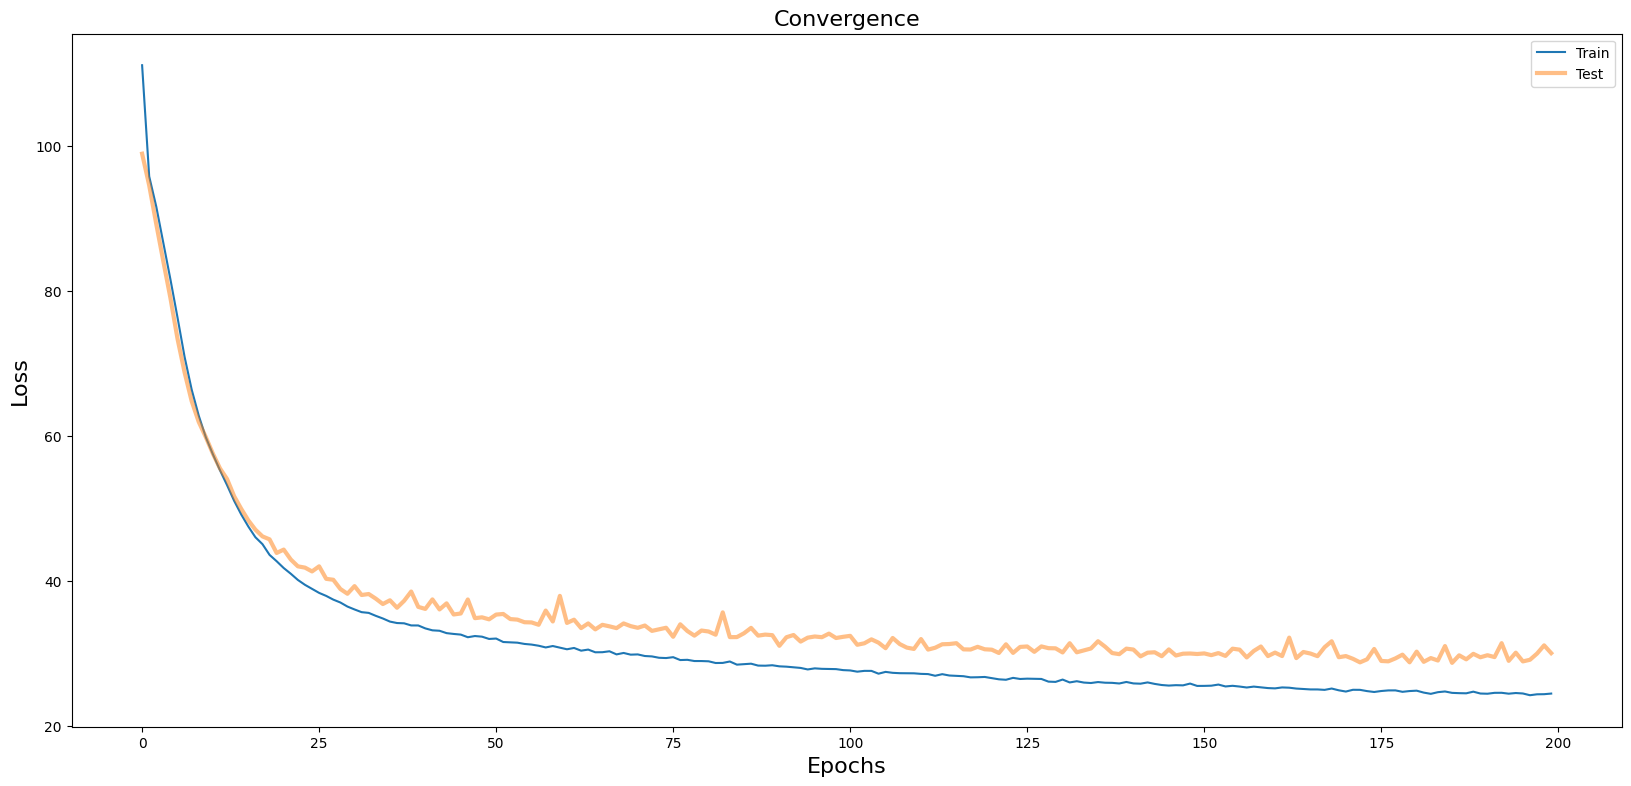

In [18]:
plt.figure(figsize=(20, 9))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergence', fontsize=16)
plt.legend()
plt.show()